# Deep Neural Network From Scratch

This notebook implements from scratch a deep neural network model for Cat image classification, aiming to understand the **underlying math** of a deep neural network.

**Reference**: the content is taken from the assignments of the [Neural Networks and Deep Learning](https://www.coursera.org/learn/neural-networks-deep-learning/home/assignments) course provided by Coursera.

## Table of Contents
- [1 - Packages](#1)
- [2 - Load and Process the Dataset](#2)
- [3 - Model Architecture](#3)
    - [3.1 - 2-layer Neural Network](#3-1)
    - [3.2 - L-layer Deep Neural Network](#3-2)
    - [3.3 - General Methodology](#3-3)
- 3' - Prerequisites
- [4 - Two-layer Neural Network](#4)
    - [two_layer_model](#ex-1)
    - [4.1 - Train the model](#4-1)
- [5 - L-layer Neural Network](#5)
    - [L_layer_model](#ex-2)
    - [5.1 - Train the model](#5-1)

<a name='1'></a>
## 1 - Packages

Begin by importing all the packages you'll need during this assignment. 

- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- `dnn_app_utils` provides the functions implemented in the "Building your Deep Neural Network: Step by Step" assignment to this notebook.
- `np.random.seed(1)` is used to keep all the random function calls consistent. It helps grade your work - so please don't change it! 

In [1]:
import time
import numpy as np
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *
from public_tests import *
from testCases import *
from dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward

import copy

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

<a name='1'></a>
## 1 - Packages

First, import all the packages you'll need during this assignment. 

- [numpy](www.numpy.org) is the main package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- dnn_utils provides some necessary functions for this notebook.
- testCases provides some test cases to assess the correctness of your functions
- np.random.seed(1) is used to keep all the random function calls consistent. It helps grade your work. Please don't change the seed! 

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from testCases import *
from dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward
from public_tests import *

import copy
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

<a name='2'></a>
## 2 - Load and Process the Dataset

You'll be using the same "Cat vs non-Cat" dataset as in "Logistic Regression as a Neural Network" (Assignment 2). The model you built back then had 70% test accuracy on classifying cat vs non-cat images. Hopefully, your new model will perform even better!

**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of `m_train` images labelled as cat (1) or non-cat (0)
    - a test set of `m_test` images labelled as cat and non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Let's get more familiar with the dataset. Load the data by running the cell below.

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to check out other images. 

y = 0. It's a non-cat picture.


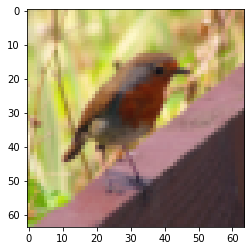

In [3]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [4]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">
<caption><center><font color='purple'><b>Figure 1</b>: Image to vector conversion.</font></center></caption>

In [5]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


**Note**:
$12,288$ equals $64 \times 64 \times 3$, which is the size of one reshaped image vector.

<a name='3'></a>
## 3 - Model Architecture

<a name='3-1'></a>
### 3.1 - 2-layer Neural Network

Now that you're familiar with the dataset, it's time to build a deep neural network to distinguish cat images from non-cat images!

You're going to build two different models:

- A 2-layer neural network
- An L-layer deep neural network

Then, you'll compare the performance of these models, and try out some different values for $L$. 

Let's look at the two architectures:

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center><font color='purple'><b>Figure 2</b>: 2-layer neural network. <br> The model can be summarized as: INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT.</font></center></caption>

<u><b>Detailed Architecture of Figure 2</b></u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- Then, add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- Multiply the resulting vector by $W^{[2]}$ and add the intercept (bias). 
- Finally, take the sigmoid of the result. If it's greater than 0.5, classify it as a cat.

<a name='3-2'></a>
### 3.2 - L-layer Deep Neural Network

It's pretty difficult to represent an L-layer deep neural network using the above representation. However, here is a simplified network representation:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center><font color='purple'><b>Figure 3</b>: L-layer neural network. <br> The model can be summarized as: [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID</font></center></caption>

<u><b>Detailed Architecture of Figure 3</b></u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, take the sigmoid of the final linear unit. If it is greater than 0.5, classify it as a cat.

<a name='3-3'></a>
### 3.3 - General Methodology

As usual, you'll follow the Deep Learning methodology to build the model:

1. Initialize parameters / Define hyperparameters
2. Loop for num_iterations:
    a. Forward propagation
    b. Compute cost function
    c. Backward propagation
    d. Update parameters (using parameters, and grads from backprop) 
3. Use trained parameters to predict labels

Now go ahead and implement those two models!

<a name='3b'></a>
## 3'. Prerequisites

The functions required for building the model in section 4.



<a name='ex-1'></a>
### initialize_parameters

Create and initialize the parameters of the 2-layer neural network.

**Instructions**:

- The model's structure is: *LINEAR -> RELU -> LINEAR -> SIGMOID*. 
- Use this random initialization for the weight matrices: `np.random.randn(d0, d1, ..., dn) * 0.01` with the correct shape. The documentation for [np.random.randn](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html)
- Use zero initialization for the biases: `np.zeros(shape)`. The documentation for [np.zeros](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html)

In [ ]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)
    
    #(≈ 4 lines of code)
    # W1 = ...
    # b1 = ...
    # W2 = ...
    # b2 = ...
    
    W1 = np.random.randn(n_h, n_x)* 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)* 0.01
    b2 = np.zeros((n_y, 1))
    
    
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

<a name='3-2'></a>
### L-layer Neural Network

The initialization for a deeper L-layer neural network is more complicated because there are many more weight matrices and bias vectors. When completing the `initialize_parameters_deep` function, you should make sure that your dimensions match between each layer. Recall that $n^{[l]}$ is the number of units in layer $l$. For example, if the size of your input $X$ is $(12288, 209)$ (with $m=209$ examples) then:

<table style="width:100%">
    <tr>
        <td>  </td> 
        <td> <b>Shape of W</b> </td> 
        <td> <b>Shape of b</b>  </td> 
        <td> <b>Activation</b> </td>
        <td> <b>Shape of Activation</b> </td> 
    <tr>
    <tr>
        <td> <b>Layer 1</b> </td> 
        <td> $(n^{[1]},12288)$ </td> 
        <td> $(n^{[1]},1)$ </td> 
        <td> $Z^{[1]} = W^{[1]}  X + b^{[1]} $ </td> 
        <td> $(n^{[1]},209)$ </td> 
    <tr>
    <tr>
        <td> <b>Layer 2</b> </td> 
        <td> $(n^{[2]}, n^{[1]})$  </td> 
        <td> $(n^{[2]},1)$ </td> 
        <td>$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$ </td> 
        <td> $(n^{[2]}, 209)$ </td> 
    <tr>
       <tr>
        <td> $\vdots$ </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$</td> 
        <td> $\vdots$  </td> 
    <tr>  
   <tr>
       <td> <b>Layer L-1</b> </td> 
        <td> $(n^{[L-1]}, n^{[L-2]})$ </td> 
        <td> $(n^{[L-1]}, 1)$  </td> 
        <td>$Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ </td> 
        <td> $(n^{[L-1]}, 209)$ </td> 
   <tr>
   <tr>
       <td> <b>Layer L</b> </td> 
        <td> $(n^{[L]}, n^{[L-1]})$ </td> 
        <td> $(n^{[L]}, 1)$ </td>
        <td> $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$</td>
        <td> $(n^{[L]}, 209)$  </td> 
    <tr>
</table>

Remember that when you compute $W X + b$ in python, it carries out broadcasting. For example, if: 

$$ W = \begin{bmatrix}
    w_{00}  & w_{01} & w_{02} \\
    w_{10}  & w_{11} & w_{12} \\
    w_{20}  & w_{21} & w_{22} 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    x_{00}  & x_{01} & x_{02} \\
    x_{10}  & x_{11} & x_{12} \\
    x_{20}  & x_{21} & x_{22} 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    b_0  \\
    b_1  \\
    b_2
\end{bmatrix}\tag{2}$$

Then $WX + b$ will be:

$$ WX + b = \begin{bmatrix}
    (w_{00}x_{00} + w_{01}x_{10} + w_{02}x_{20}) + b_0 & (w_{00}x_{01} + w_{01}x_{11} + w_{02}x_{21}) + b_0 & \cdots \\
    (w_{10}x_{00} + w_{11}x_{10} + w_{12}x_{20}) + b_1 & (w_{10}x_{01} + w_{11}x_{11} + w_{12}x_{21}) + b_1 & \cdots \\
    (w_{20}x_{00} + w_{21}x_{10} + w_{22}x_{20}) + b_2 &  (w_{20}x_{01} + w_{21}x_{11} + w_{22}x_{21}) + b_2 & \cdots
\end{bmatrix}\tag{3}  $$


<a name='ex-2'></a>
#### initialize_parameters_deep

Implement initialization for an L-layer Neural Network. 

**Instructions**:
- The model's structure is *[LINEAR -> RELU] $ \times$ (L-1) -> LINEAR -> SIGMOID*. I.e., it has $L-1$ layers using a ReLU activation function followed by an output layer with a sigmoid activation function.
- Use random initialization for the weight matrices. Use `np.random.randn(d0, d1, ..., dn) * 0.01`.
- Use zeros initialization for the biases. Use `np.zeros(shape)`.
- Store $n^{[l]}$, the number of units in different layers, in a variable `layer_dims`. For example, the `layer_dims` for last week's Planar Data classification model would have been [2,4,1]: There were two inputs, one hidden layer with 4 hidden units, and an output layer with 1 output unit. This means `W1`'s shape was (4,2), `b1` was (4,1), `W2` was (1,4) and `b2` was (1,1). Now you will generalize this to $L$ layers! 
```

In [ ]:

def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        #(≈ 2 lines of code)
        # parameters['W' + str(l)] = ...
        # parameters['b' + str(l)] = ...
        
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))
        
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

<a name='4-1'></a>
### Linear Forward 

Now that you have initialized your parameters, you can do the forward propagation module. Start by implementing some basic functions that you can use again later when implementing the model. Now, you'll complete three functions in this order:

- LINEAR
- LINEAR -> ACTIVATION where ACTIVATION will be either ReLU or Sigmoid. 
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID (whole model)

The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$

where $A^{[0]} = X$. 

<a name='ex-3'></a>
#### linear_forward 

Build the linear part of forward propagation.

**Reminder**:
The mathematical representation of this unit is $Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$. You may also find `np.dot()` useful. If your dimensions don't match, printing `W.shape` may help.

In [ ]:

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    #(≈ 1 line of code)
    # Z = ...
    
    Z = np.dot(W, A) + b
    
    
    cache = (A, W, b)
    
    return Z, cache

<a name='4-2'></a>
### Linear-Activation Forward

In this notebook, you will use two activation functions:

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. You've been provided with the `sigmoid` function which returns **two** items: the activation value "`a`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it you could just call: 
``` python
A, activation_cache = sigmoid(Z)
```

- **ReLU**: The mathematical formula for ReLu is $A = RELU(Z) = max(0, Z)$. You've been provided with the `relu` function. This function returns **two** items: the activation value "`A`" and a "`cache`" that contains "`Z`" (it's what you'll feed in to the corresponding backward function). To use it you could just call:
``` python
A, activation_cache = relu(Z)
```

For added convenience, you're going to group two functions (Linear and Activation) into one function (LINEAR->ACTIVATION). Hence, you'll implement a function that does the LINEAR forward step, followed by an ACTIVATION forward step.

<a name='ex-4'></a>
#### linear_activation_forward

Implement the forward propagation of the *LINEAR->ACTIVATION* layer. Mathematical relation is: $A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})$ where the activation "g" can be sigmoid() or relu(). Use `linear_forward()` and the correct activation function.

In [ ]:

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        #(≈ 2 lines of code)
        # Z, linear_cache = ...
        # A, activation_cache = ...
        
        Z, linear_cache = linear_forward(A=A_prev, W=W, b=b)
        A, activation_cache = sigmoid(Z)
        
    
    elif activation == "relu":
        #(≈ 2 lines of code)
        # Z, linear_cache = ...
        # A, activation_cache = ...
        
        Z, linear_cache = linear_forward(A=A_prev, W=W, b=b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)

    return A, cache

<a name='6-2'></a>
### Linear-Activation Backward

Create a function that merges the two helper functions: **`linear_backward`** and the backward step for the activation **`linear_activation_backward`**. 

Two backward functions have been provided:
- **`sigmoid_backward`**: Implements the backward propagation for SIGMOID unit. 

```python
dZ = sigmoid_backward(dA, activation_cache)
```

- **`relu_backward`**: Implements the backward propagation for RELU unit. You can call it as follows:

```python
dZ = relu_backward(dA, activation_cache)
```

If $g(.)$ is the activation function, 
`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}). \tag{11}$$  

<a name='ex-8'></a>
#### linear_activation_backward

Implement the backpropagation for the *LINEAR->ACTIVATION* layer.

In [ ]:

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    ### START CODE HERE ### (≈ 3 lines of code)
    # dW = ...
    # db = ... sum by the rows of dZ with keepdims=True
    # dA_prev = ...
    
    dW = 1/m*np.dot(dZ, A_prev.T)
    db = 1/m*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    
    return dA_prev, dW, db

In [ ]:

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        #(≈ 2 lines of code)
        # dZ =  ...
        # dA_prev, dW, db =  ...
        
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ=dZ, cache=linear_cache)
        
        
    elif activation == "sigmoid":
        #(≈ 2 lines of code)
        # dZ =  ...
        # dA_prev, dW, db =  ...
        
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ=dZ, cache=linear_cache)
        
        
    
    return dA_prev, dW, db

<a name='4-3'></a>
### L-Layer Model 

For even *more* convenience when implementing the $L$-layer Neural Net, we will need a function that replicates the previous one (`linear_activation_forward` with RELU) $L-1$ times, then follows that with one `linear_activation_forward` with SIGMOID.

<img src="images/model_architecture_kiank.png" style="width:600px;height:300px;">
<caption><center> <b>Figure 2</b> : *[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* model</center></caption><br>

<a name='ex-5'></a>
#### L_model_forward

Implement the forward propagation of the above model.

**Instructions**: In the code below, the variable `AL` will denote $A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$. (This is sometimes also called `Yhat`, i.e., this is $\hat{Y}$.) 

In [ ]:

def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- activation value from the output (last) layer
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    # The for loop starts at 1 because layer 0 is the input
    for l in range(1, L):
        A_prev = A 
        #(≈ 2 lines of code)
        # A, cache = ...
        # caches ...
        
        W = parameters.get(f'W{l}')
        b = parameters.get(f'b{l}')
        A, cache = linear_activation_forward(A_prev=A_prev, W=W, b=b, activation='relu')
        caches.append(cache)
        
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    #(≈ 2 lines of code)
    # AL, cache = ...
    # caches ...
    
    AL, cache = linear_activation_forward(A_prev=A, W=parameters.get(f'W{L}'), b=parameters.get(f'b{L}'), activation='sigmoid')
    caches.append(cache)
    
          
    return AL, caches

<a name='6-3'></a>
#### L-Model Backward 

Implement the backward function for the whole network! 

Recall that when we implemented the `L_model_forward` function, at each iteration, stored a cache which contains (X,W,b, and z). In the back propagation module, use those variables to compute the gradients. Therefore, in the `L_model_backward` function, iterate through all the hidden layers backward, starting from layer $L$. On each step, we will use the cached values for layer $l$ to backpropagate through layer $l$. Figure 5 below shows the backward pass. 


<img src="images/mn_backward.png" style="width:450px;height:300px;">
<caption><center><font color='purple'><b>Figure 5</b>: Backward pass</font></center></caption>

**Initializing backpropagation**:

To backpropagate through this network, we know that the output is: 
$A^{[L]} = \sigma(Z^{[L]})$. Your code thus needs to compute `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$.
To do so, use this formula (derived using calculus which, again, we don't need in-depth knowledge of!):
```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
```

Use this post-activation gradient `dAL` to keep going backward. As seen in Figure 5, we can now feed in `dAL` into the LINEAR->SIGMOID backward function we implemented (which will use the cached values stored by the L_model_forward function). 

After that, we will have to use a `for` loop to iterate through all the other layers using the LINEAR->RELU backward function. we should store each dA, dW, and db in the grads dictionary. To do so, use this formula : 

$$grads["dW" + str(l)] = dW^{[l]}\tag{15} $$

For example, for $l=3$ this would store $dW^{[l]}$ in `grads["dW3"]`.

<a name='ex-9'></a>
#### L_model_backward

Implement backpropagation for the *[LINEAR->RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* model.

In [ ]:

def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    #(1 line of code)
    # dAL = ...
    
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
    
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA=dAL, cache=current_cache, activation='sigmoid')
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 

        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA=grads["dA" + str(l+1)], cache=current_cache, activation='relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        

    return grads

<a name='5'></a>
### Cost Function

Implement forward and backward propagation! You need to compute the cost, in order to check whether your model is actually learning.

<a name='ex-6'></a>
#### compute_cost
Compute the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$


In [ ]:

def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    # (≈ 1 lines of code)
    # cost = ...
    
    cost = -1/m*np.sum(np.multiply(Y,np.log(AL)) + np.multiply((1-Y),np.log(1-AL)))
    print(cost)
    
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).

    
    return cost

<a name='ex-10'></a>
### update_parameters

Implement `update_parameters()` to update your parameters using gradient descent.

**Instructions**:
Update parameters using gradient descent on every $W^{[l]}$ and $b^{[l]}$ for $l = 1, 2, ..., L$. 

In [ ]:

def update_parameters(params, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    params -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    parameters = copy.deepcopy(params)
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = params.get("W" + str(l+1)) - learning_rate*grads.get("dW" + str(l+1))
        parameters["b" + str(l+1)] = params.get("b" + str(l+1)) - learning_rate*grads.get("db" + str(l+1))
        
    return parameters

### predict
There are two steps to computing predictions:

Calculate  𝑌̂ =𝐴=𝜎(𝑤𝑇𝑋+𝑏)
 
Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [ ]:

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    #(≈ 1 line of code)
    # A = ...
    z = np.dot(w.T,X) + b
    A = sigmoid(z)
        
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        #(≈ 4 lines of code)
        # if A[0, i] > ____ :
        #     Y_prediction[0,i] = 
        # else:
        #     Y_prediction[0,i] = 
        if A[0, i] > 0.5:
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
        
    
    return Y_prediction

<a name='4'></a>
## 4 - Two-layer Neural Network

<a name='ex-1'></a>
### two_layer_model 

Use the helper functions you have implemented in the previous assignment to build a 2-layer neural network with the following structure: *LINEAR -> RELU -> LINEAR -> SIGMOID*. The functions and their inputs are:
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [6]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

In [7]:

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    #(≈ 1 line of code)
    # parameters = ...
    
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        #(≈ 2 lines of code)
        # A1, cache1 = ...
        # A2, cache2 = ...
        
        A1, cache1 = linear_activation_forward(A_prev=X, W=W1, b=b1, activation='relu')
        A2, cache2 = linear_activation_forward(A_prev=A1, W=W2, b=b2, activation='sigmoid')
        
        
        # Compute cost
        #(≈ 1 line of code)
        # cost = ...
        
        cost = compute_cost(A2, Y)
        
        
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        #(≈ 2 lines of code)
        # dA1, dW2, db2 = ...
        # dA0, dW1, db1 = ...
        
        dA1, dW2, db2 = linear_activation_backward(dA=dA2, cache=cache2, activation='sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA=dA1, cache=cache1, activation='relu')
        
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        #(approx. 1 line of code)
        # parameters = ...
        
        parameters = update_parameters(parameters=parameters, grads=grads, learning_rate=learning_rate)
        
        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

<a name='4-1'></a>
### 4.1 - Train the model 

If your code passed the previous cell, run the cell below to train your parameters. 

- The cost should decrease on every iteration. 

- It may take up to 5 minutes to run 2500 iterations. 

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.43391631512257495
Cost after iteration 800: 0.4007977536203886
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366413
Cost after iteration 1100: 0.30527536361962654
Cost after iteration 1200: 0.2749137728213015
Cost after iteration 1300: 0.2468176821061484
Cost after iteration 1400: 0.19850735037466102
Cost after iteration 1500: 0.17448318112556638
Cost after iteration 1600: 0.1708076297809692
Cost after iteration 1700: 0.11306524562164715
Cost after iteration 1800: 0.09629426845937156
Cost after iteration 1900: 0.0834261795972687
Cost after iteration 2000: 0.07439078704319085
Cost after iteration 2100: 0.06630748132

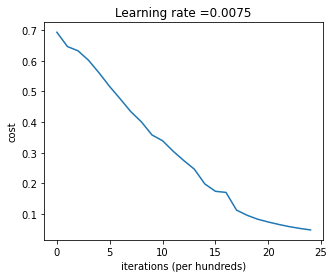

In [9]:
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)
plot_costs(costs, learning_rate)

**Expected Output**:
<table> 
    <tr>
        <td> <b>Cost after iteration 0</b></td>
        <td> 0.6930497356599888 </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 100</b></td>
        <td> 0.6464320953428849 </td>
    </tr>
    <tr>
        <td> <b>...</b></td>
        <td> ... </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 2499</b></td>
        <td> 0.04421498215868956 </td>
    </tr>
</table>

**Nice!** You successfully trained the model. Good thing you built a vectorized implementation! Otherwise it might have taken 10 times longer to train this.

Now, you can use the trained parameters to classify images from the dataset. To see your predictions on the training and test sets, run the cell below.

In [10]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [11]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


<a name='5'></a>
## 5 - L-layer Neural Network

<a name='ex-2'></a>
### L_layer_model 

Use the helper functions you implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. The functions and their inputs are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [ ]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [12]:

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    #(≈ 1 line of code)
    # parameters = ...
    
    parameters = initialize_parameters_deep(layers_dims)
    
    
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        #(≈ 1 line of code)
        # AL, caches = ...
        
        AL, caches = L_model_forward(X=X, parameters=parameters)
        
        
        
        # Compute cost.
        #(≈ 1 line of code)
        # cost = ...
        
        cost = compute_cost(AL, Y)
    
    
        # Backward propagation.
        #(≈ 1 line of code)
        # grads = ...    
        
        grads = L_model_backward(AL, Y, caches)
        
        
 
        # Update parameters.
        #(≈ 1 line of code)
        # parameters = ...
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        
                
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

In [13]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 1, print_cost = False)

print("Cost after first iteration: " + str(costs[0]))


Cost after iteration 0: 0.6950464961800915
Cost after first iteration: 0.6950464961800915
Cost after iteration 1: 0.7070709008912569
Cost after iteration 1: 0.7070709008912569
Cost after iteration 1: 0.7070709008912569
Cost after iteration 2: 0.7063462654190897
 All tests passed.


<a name='5-1'></a>
### 5.1 - Train the model 

If your code passed the previous cell, run the cell below to train your model as a 4-layer neural network. 

- The cost should decrease on every iteration. 

- It may take up to 5 minutes to run 2500 iterations. 

In [14]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

Cost after iteration 0: 0.6950464961800915
Cost after iteration 100: 0.5892596054583805
Cost after iteration 200: 0.5232609173622991
Cost after iteration 300: 0.4497686396221906
Cost after iteration 400: 0.4209002161883899
Cost after iteration 500: 0.37246403061745953
Cost after iteration 600: 0.3474205187020191
Cost after iteration 700: 0.31719191987370265
Cost after iteration 800: 0.2664377434774658
Cost after iteration 900: 0.21991432807842573
Cost after iteration 1000: 0.1435789889362377
Cost after iteration 1100: 0.4530921262322132
Cost after iteration 1200: 0.09499357670093511
Cost after iteration 1300: 0.08014128076781366
Cost after iteration 1400: 0.0694023400553646
Cost after iteration 1500: 0.060216640231745895
Cost after iteration 1600: 0.05327415758001879
Cost after iteration 1700: 0.04762903262098432
Cost after iteration 1800: 0.04297588879436867
Cost after iteration 1900: 0.03903607436513823
Cost after iteration 2000: 0.03568313638049028
Cost after iteration 2100: 0.03291

In [15]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [16]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.74


Accuracy: 1.0
y = 0.0, your L-layer model predicts a "non-cat" picture.


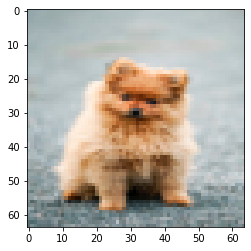

In [18]:
my_image = "pexels-photo-3687770.jpeg" # change this to the name of your image file 
my_label_y = [0] # the true class of your image (1 -> cat, 0 -> non-cat)

fname = "images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, parameters)


print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

**References**:
- Neural Networks and Deep Learning: https://www.coursera.org/learn/neural-networks-deep-learning/home
- for auto-reloading external module: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython